In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import linear_model

In [214]:
os.getcwd()

'C:\\Users\\olubl\\OneDrive\\14th grade\\PDEW_Predict'

In [215]:
#let's read in the PDEW dataframe. This is already filtered to only the 3rd quarter of 2024 using an sql query in the dot website.
all_pdew = pd.read_csv('C:\\Users\\olubl\\OneDrive\\14th grade\\PDEW_Predict\\data\\pdew_3q_2024.csv')
all_pdew = all_pdew[['Year','quarter','city1','city2','nsmiles','passengers','fare','carrier_lg']]

In [216]:
all_pdew.head()

,Year,quarter,city1,city2,nsmiles,passengers,fare,carrier_lg
0,2024,3,"Allentown/Bethlehem/Easton, PA","Dallas/Fort Worth, TX",1307,18,367.69,AA
1,2024,3,"Allentown/Bethlehem/Easton, PA","Denver, CO",1539,89,138.60,G4
2,2024,3,"Allentown/Bethlehem/Easton, PA","Atlanta, GA (Metropolitan Area)",692,107,319.69,DL
3,2024,3,"Allentown/Bethlehem/Easton, PA","Austin, TX",1441,13,256.48,AA
4,2024,3,"Allentown/Bethlehem/Easton, PA","Nashville, TN",685,46,130.88,G4


In [217]:
all_pdew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6611 entries, 0 to 6610
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        6611 non-null   int64  
 1   quarter     6611 non-null   int64  
 2   city1       6611 non-null   object 
 3   city2       6611 non-null   object 
 4   nsmiles     6611 non-null   int64  
 5   passengers  6611 non-null   int64  
 6   fare        6611 non-null   float64
 7   carrier_lg  6611 non-null   object 
dtypes: float64(1), int64(4), object(3)
memory usage: 413.3+ KB


In [218]:
#the dataframe has entries from 6611 different city pairs. We check the quality of the data
all_pdew.isnull().any()

Year          False
quarter       False
city1         False
city2         False
nsmiles       False
passengers    False
fare          False
carrier_lg    False
dtype: bool

In [219]:
#let's look at some of the entries for city names
all_pdew['city1'].unique()[:20]

array(['Allentown/Bethlehem/Easton, PA', 'Abilene, TX', 'Albuquerque, NM',
       'Aberdeen, SD', 'Nantucket, MA', 'Appleton, WI',
       'Eureka/Arcata, CA', 'Atlantic City, NJ', 'Alexandria, LA',
       'Colorado Springs, CO', 'Phoenix, AZ', 'Dallas/Fort Worth, TX',
       'Butte, MT', 'Pittsburgh, PA', 'Augusta, GA', 'Huntsville, AL',
       'Albany, NY', 'Amarillo, TX', 'Durango, CO', 'Denver, CO'],
      dtype=object)

In [220]:
#to simplify the data, let's only include the first (primary) city of multiplexed metro areas.

def map_cities(city):
    #remove the (Metropolitan Area) term
    to_remove = ' (Metropolitan Area)'
    simplified = city.replace(to_remove,"")
    
    #let's extract the state
    str_split = simplified.split(', ')
    metro = str_split[0]
    state = str_split[1]  

    #now we only take the first city named
    primary = metro.split('/')[0]
    return primary + ", " + state


In [221]:
all_pdew['city1'] = all_pdew['city1'].apply(map_cities)
all_pdew['city2'] = all_pdew['city2'].apply(map_cities)

R^2 value: 0.2766


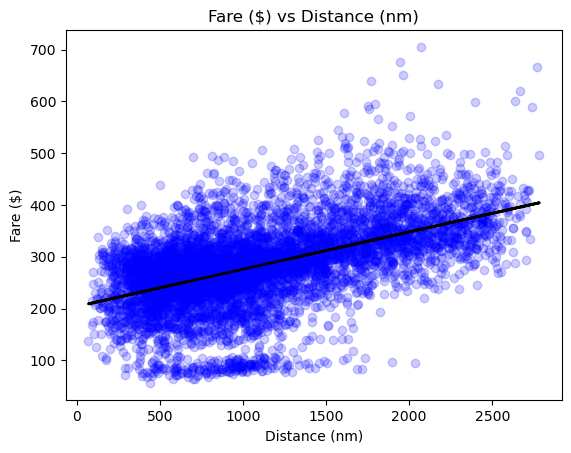

In [222]:
#linear regression on fare vs distance

x = all_pdew['nsmiles'].values    #predictor variable
y = all_pdew['fare'].values       #response variable

#we need to reshape the predictor variable from an array to a column vector
X = x.reshape(-1, 1)

model = linear_model.LinearRegression()
model.fit(X,y)

plt.scatter(X,y,color='blue',alpha=0.2)     
plt.plot(X,model.predict(X),color='black',linewidth='2')           #this plots the least squares regression line
plt.title('Fare ($) vs Distance (nm)')
plt.xlabel('Distance (nm)')
plt.ylabel('Fare ($)')

#let's get the r^2 value also
print(f'R^2 value: {model.score(X,y):.4}')

Text(0, 0.5, 'Fare ($)')

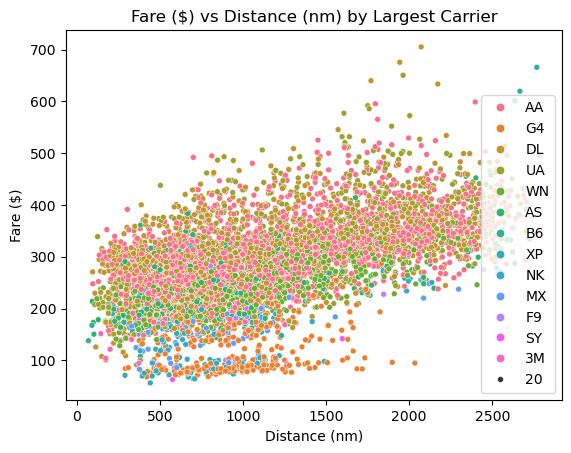

In [223]:
#we color code the scatter plot based on the categorical carrier_lg variable
carriers = all_pdew['carrier_lg'].values
#seaborn requires us to flatten the carrier list to a one dimensional array, which we do with .ravel(). Hue is the grouping variable by carrier.
sns.scatterplot(x=X.ravel(),y=y,hue=z,size=20)

plt.title('Fare ($) vs Distance (nm) by Largest Carrier')
plt.xlabel('Distance (nm)')
plt.ylabel('Fare ($)')

In [224]:
#this better lets us visualize clear differences by carrier, with G4 and NK comprising most of the lowest avg fare (~$100) routes.
#now we plot the weighted average fare on routes where each carrier is the largest.

avg_fare_by_carrier = pd.DataFrame(all_pdew.groupby('carrier_lg',as_index=False).apply(
    lambda x: np.average(x['fare'], weights=x['passengers']),
    include_groups=False)
                                  )
                                         
avg_fare_by_carrier.columns = ['carrier_lg', 'avg_fare']
avg_fare_by_carrier = avg_fare_by_carrier.sort_values(by='avg_fare',ascending=False)
avg_fare_by_carrier

,carrier_lg,avg_fare
10,UA,260.035988
1,AA,251.367022
4,DL,237.032842
3,B6,228.383484
2,AS,225.692683
11,WN,207.661374
9,SY,194.433438
8,NK,173.390292
5,F9,170.635599
7,MX,166.728838


Text(0.5, 1.0, 'Average Fare in Dominant Markets by Carrier')

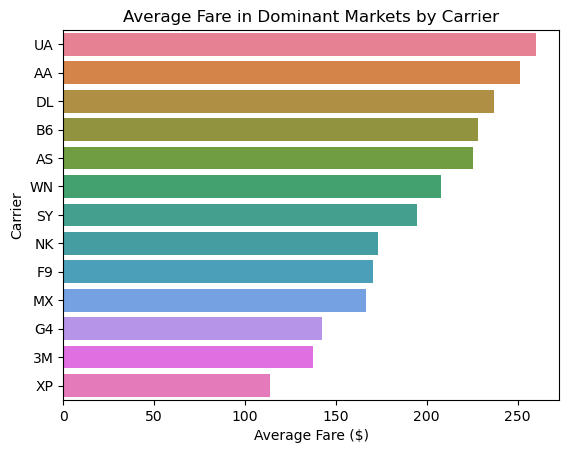

In [225]:
#now we plot this data
fig,ax=plt.subplots()
sns.barplot(data=avg_fare_by_carrier,x='avg_fare',y='carrier_lg',hue='carrier_lg')
plt.ylabel('Carrier')
plt.xlabel('Average Fare ($)')
plt.title('Average Fare in Dominant Markets by Carrier')